In [1]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


In [19]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

In [2]:
def temperature_scaling(logits, y):
    def temperature_obj(t):
        temp_logits = logits / (t )
        return log_loss(y, temp_logits)
    
    res = minimize_scalar(temperature_obj)
    return logits / (res.x )

In [3]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [4]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=20)
    return prob_true, prob_pred


In [5]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [6]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [7]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return   np.exp(p)/(1 + np.exp(p))

In [11]:
devpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.dev_preds")

with open(devpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [12]:
testpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [13]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)


tp= np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold0 =   np.array(M_test['golds'],dtype = int)

In [ ]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

In [ ]:
def temperature_multi (p1, p2,p3,p4, 
                      y1, y2, y3, y4):
    def temperature_obj(t):
        logi_1 = (p1 )  / t[5] 
        logi_2 = (p2  )  / t[6] 
        logi_3 = (p3  )  / t[7] 
        logi_4 = (p4  )  / t[8] 
        
        probs1  =  t[9]* expit (t[0]*   logi_1  )  
        probs2  =  t[9]* expit (  t[0] *  logi_2  )  
        probs3  =  t[9]* expit (t[0] *  logi_3  )  
        probs4  =t[9]  *expit ( t[0] *  logi_4  ) 
        
        total_loss = log_loss(y1, probs1)+log_loss(y2, probs2)+log_loss(y3,probs3) + log_loss(y4,probs4)
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, .1,
                                         .1, .1,.1, .1, .1 ] )
    
    #normed =  expit( r.x[0] * np.concatenate([p1/r.x[1], p2/r.x[2], p3/r.x[3], p4/r.x[4]]))  
    return  r

In [9]:
def temperature_multi_8(p1, p2,p3,p4, 
                      y1, y2, y3, y4):
    def temperature_obj(t):
        logi_1 = (p1 +  t[1])  / t[5] 
        logi_2 = (p2 +  t[2])  / t[6] 
        logi_3 = (p3 +  t[3])  / t[7] 
        logi_4 = (p4 +  t[4])  / t[8] 
        
        probs1  =  t[9]* expit (t[0]*   logi_1  )  
        probs2  =  t[9]* expit (  t[0] *  logi_2  )  
        probs3  =  t[9]* expit (t[0] *  logi_3  )  
        probs4  =t[9]  *expit ( t[0] *  logi_4  ) 
        
        total_loss = log_loss(y1, probs1)+log_loss(y2, probs2)+log_loss(y3,probs3) + log_loss(y4,probs4)
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, .1,
                                         .1, .1,.1, .1, .1 ] )
    
    #normed =  expit( r.x[0] * np.concatenate([p1/r.x[1], p2/r.x[2], p3/r.x[3], p4/r.x[4]]))  
    return  r

In [14]:
tt  = temperature_multi_8( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                                         gold1, gold2, gold3, gold4)

In [245]:
tt.x

array([0.1297842 , 1.63535154, 1.57635189, 1.32761494, 1.52126241,
       0.08405857, 0.08732938, 0.09570688, 0.06988549, 0.06969072])

In [15]:
tc1 = ( expit( tt.x[0]*( logit(tp1) + tt.x[1] ) / tt.x[5] ) ) #*tt.x[9]
tc2 = ( expit( tt.x[0]*( logit(tp2) + tt.x[2] ) / tt.x[6] ) ) #*tt.x[9]
tc3 = ( expit( tt.x[0]*( logit(tp3) + tt.x[3] ) / tt.x[7] ) ) #*tt.x[9]
tc4 = ( expit( tt.x[0]*( logit(tp4) + tt.x[4] ) / tt.x[8] ) ) #*tt.x[9]


(array([1498., 1256., 1174., 1242., 1460., 1722., 2022., 2150., 2384.,
        1224.]),
 array([0.00698307, 0.10267618, 0.1983693 , 0.29406241, 0.38975553,
        0.48544864, 0.58114176, 0.67683487, 0.77252799, 0.8682211 ,
        0.96391422]),
 <BarContainer object of 10 artists>)

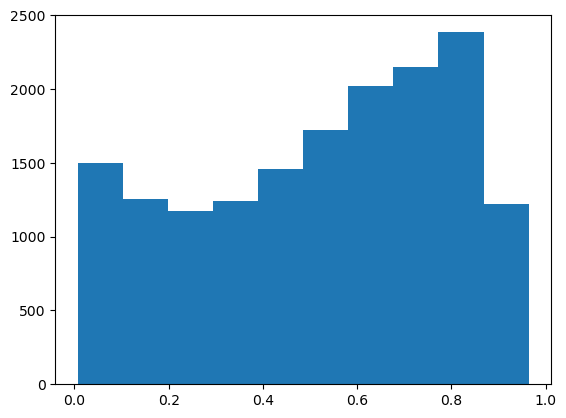

In [20]:
plt.hist(tc1)

In [21]:
y1, p1 = compute_calibration_curve(M_test1['golds'], tc1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], tc2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], tc3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], tc4 )


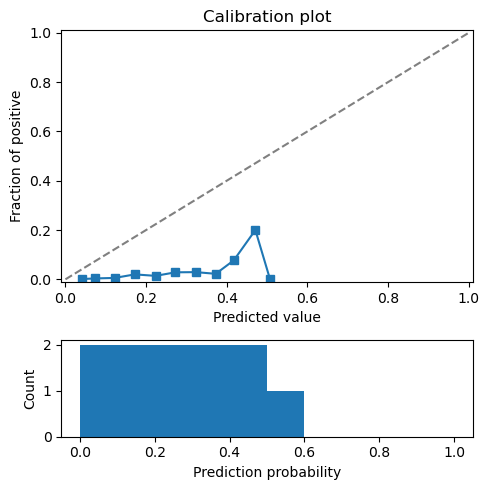

In [22]:
plotter(p4, y4)

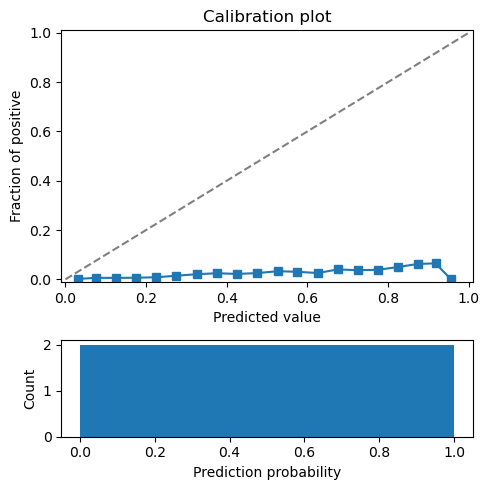

In [23]:
plotter(p1, y1)

In [24]:
import sklearn
from sklearn.metrics import confusion_matrix

In [27]:
sklearn.metrics.roc_auc_score(tgold1,  tc1 , average = 'samples')


0.6667921165559247

In [28]:
sklearn.metrics.roc_auc_score(tgold2,  tc2 , average = 'samples')


0.6764938403022082

In [29]:
sklearn.metrics.roc_auc_score(tgold3,  tc3 , average = 'samples')


0.7132108023602834

In [30]:
sklearn.metrics.roc_auc_score(tgold4,  tc4 , average = 'samples')


0.754709382855384

In [31]:
( confusion_matrix (tgold1,  tc1>.5) )

array([[6778, 8874],
       [  95,  385]], dtype=int64)

In [32]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[11112,  2894],
       [  133,    87]], dtype=int64)

In [33]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12240,   436],
       [  139,    14]], dtype=int64)

In [34]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[11578,     2],
       [  101,     0]], dtype=int64)

In [231]:
( confusion_matrix (tgold1,  tp1>.05) )

array([[ 1657, 13862],
       [   10,   496]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])